<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-准备数据" data-toc-modified-id="1-准备数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1 准备数据</a></span><ul class="toc-item"><li><span><a href="#1.1-加载数据" data-toc-modified-id="1.1-加载数据-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1.1 加载数据</a></span></li><li><span><a href="#1.2-日期列转换" data-toc-modified-id="1.2-日期列转换-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>1.2 日期列转换</a></span></li><li><span><a href="#1.3-按天上采样" data-toc-modified-id="1.3-按天上采样-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>1.3 按天上采样</a></span></li></ul></li><li><span><a href="#2-EDA" data-toc-modified-id="2-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2 EDA</a></span><ul class="toc-item"><li><span><a href="#2.1-JetRail高铁的每日乘客数量时序图" data-toc-modified-id="2.1-JetRail高铁的每日乘客数量时序图-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2.1 JetRail高铁的每日乘客数量时序图</a></span></li><li><span><a href="#2.2-seasonal_decompose" data-toc-modified-id="2.2-seasonal_decompose-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2.2 seasonal_decompose</a></span></li><li><span><a href="#2.3-时间序列的ADF检验（单位根检验）" data-toc-modified-id="2.3-时间序列的ADF检验（单位根检验）-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>2.3 时间序列的ADF检验（单位根检验）</a></span></li></ul></li><li><span><a href="#3-尝试通过ARIMA建模" data-toc-modified-id="3-尝试通过ARIMA建模-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3 尝试通过ARIMA建模</a></span></li><li><span><a href="#4-拆分训练集和测试集" data-toc-modified-id="4-拆分训练集和测试集-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4 拆分训练集和测试集</a></span></li><li><span><a href="#5-Prophet建模" data-toc-modified-id="5-Prophet建模-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>5 Prophet建模</a></span><ul class="toc-item"><li><span><a href="#5.1-训练及预测" data-toc-modified-id="5.1-训练及预测-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>5.1 训练及预测</a></span></li><li><span><a href="#5.2-测试集预测值与真实值对比" data-toc-modified-id="5.2-测试集预测值与真实值对比-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>5.2 测试集预测值与真实值对比</a></span></li><li><span><a href="#5.3-预测未来7个月乘客数" data-toc-modified-id="5.3-预测未来7个月乘客数-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>5.3 预测未来7个月乘客数</a></span></li></ul></li><li><span><a href="#6-总结：" data-toc-modified-id="6-总结：-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>6 总结：</a></span></li></ul></div>

JetRail高铁的乘客数量预测<br/>
数据集：jetrail.csv，根据过往两年的数据（2012 年 8 月至 2014 年 9月），需要用这些数据预测接下来 7 个月的乘客数量<br/>
以每天为单位聚合数据集<br/>

In [1]:
# 该API在version 0.12.1 中已废弃
# from statsmodels.api.tsa import seasonal_decompose
import statsmodels as sm
sm.__version__  # '0.12.1'

'0.12.1'

In [2]:
from itertools import product 
from calendar import month

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose  # version 0.12.1的新API
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

from fbprophet import Prophet
from fbprophet.plot import plot_forecast_component # 绘制单成分
from fbprophet.plot import add_changepoints_to_plot # 显示突变点
from chinese_calendar import get_holidays
from chinese_calendar import get_holiday_detail


sns.set_context('notebook')
sns.set_style('darkgrid')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1 准备数据
## 1.1 加载数据

In [3]:
df = pd.read_csv("train.csv", usecols=[1, 2])
df.shape

(18288, 2)

In [4]:
df.head(2)

,Datetime,Count
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2


## 1.2 日期列转换

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')

In [6]:
# 重命名列名，二者等价
# df = df.rename({'Datetime': 'ds', 'Count':'y'}, axis=1)
df = df.rename(columns={'Datetime': 'ds', 'Count':'y'})
df['ds'].min(), df['ds'].max()

(Timestamp('2012-08-25 00:00:00'), Timestamp('2014-09-25 23:00:00'))

## 1.3 按天上采样

In [7]:
df = df.resample(rule='D', on='ds').sum()
df.head(2)

,y
ds,
2012-08-25,76
2012-08-26,88


# 2 EDA

## 2.1 JetRail高铁的每日乘客数量时序图

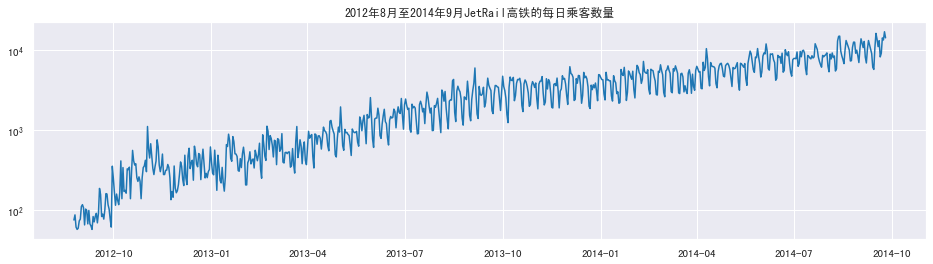

In [8]:
plt.figure(figsize=(16, 4))
plt.plot(df['y'])
plt.title("2012年8月至2014年9月JetRail高铁的每日乘客数量")
plt.yscale('log')

呈长期递增趋势，且存在波动

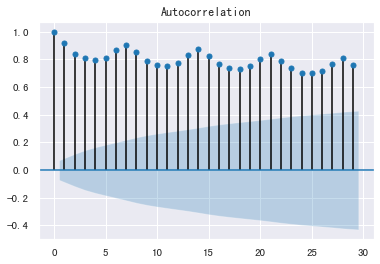

In [9]:
_ = plot_acf(df)

自相关图显示序列自相关系数长期位于零轴的一边，这是具有单调趋势序列的典型特征，同时自相关图呈现出明显的正弦波动规律，这是具有周期变化规律的非平稳序列的典型特征。

## 2.2 seasonal_decompose

In [10]:
# 可视化指定区间内的数据
def plot_stl(data, period):
    # STL返回3个部分，趋势、季节、残差
    result = seasonal_decompose(data, period=period)
    fig = result.plot()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    plt.show()
    return result

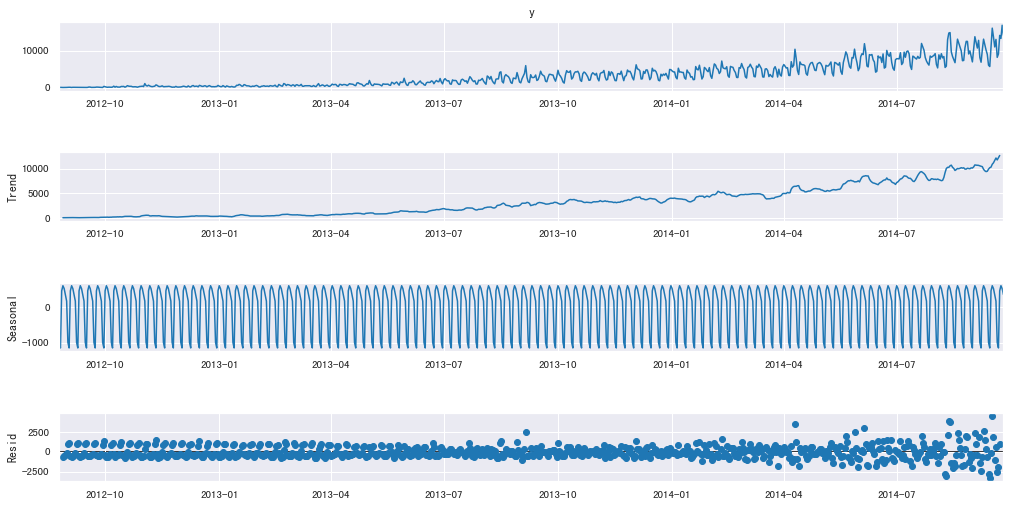

In [11]:
result = plot_stl(df['y'], period=None)

## 2.3 时间序列的ADF检验（单位根检验）

In [12]:
def myadfuller(data):
    adf = adfuller(data)
    print(f"adf检验统计量为: {adf[0]:.4f}")
    print(f"adf检验Pvalue为: {adf[1]:.4f}")
    print(f"结果使用的延迟阶数: {adf[2]}")
    print(f"ADF回归和计算临界值所使用的观察次数: {adf[3]}")
    print(
        f"99%置信度的临界值为: {adf[4]['1%']:.4f} \n95%置信度的临界值为: {adf[4]['5%']:.4f} \n90%置信度的临界值为:{adf[4]['10%']:.4f}"
    )
    print(f"最大的信息准则AIC的值: {adf[5]:.4f}")

In [13]:
myadfuller(df)  # 原数据的adf检验

adf检验统计量为: 2.9864
adf检验Pvalue为: 1.0000
结果使用的延迟阶数: 20
ADF回归和计算临界值所使用的观察次数: 741
99%置信度的临界值为: -3.4392 
95%置信度的临界值为: -2.8654 
90%置信度的临界值为:-2.5689
最大的信息准则AIC的值: 11921.9438


In [14]:
myadfuller(df.diff(1).dropna()) # 一阶差分后的adf检验

adf检验统计量为: -7.9645
adf检验Pvalue为: 0.0000
结果使用的延迟阶数: 20
ADF回归和计算临界值所使用的观察次数: 740
99%置信度的临界值为: -3.4392 
95%置信度的临界值为: -2.8655 
90%置信度的临界值为:-2.5689
最大的信息准则AIC的值: 11905.6117


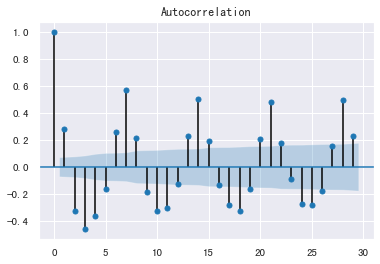

In [15]:
# 对残差做自相关图
_ = plot_acf(result.resid.dropna().values.squeeze())

残差均超出2倍标准差范围，说明残差仍然蕴含着某些信息没提取出来。

# 3 尝试通过ARIMA建模

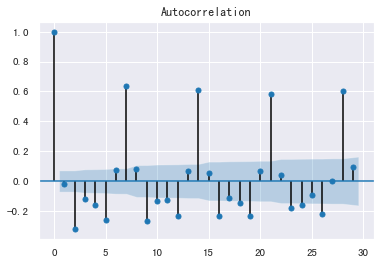

In [16]:
# 对1阶差分后的序列做自相关图
_ = plot_acf(df.diff(1).dropna())

1阶差分后仍然存在相关性。

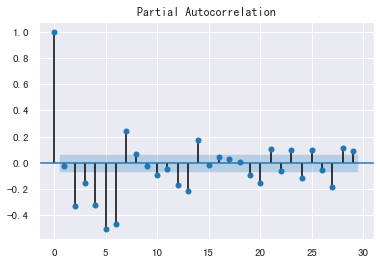

In [17]:
# 对1阶差分后的序列做偏自相关图
_ = plot_pacf(df.diff(1).dropna())

In [18]:
# # 设置p d q阶的范围，笛卡尔积
# params = product(range(8), range(1, 3), range(8))
# result = []
# best_aic = float('inf')
# for param in params:
#     try:
#         arima = ARIMA(df, order=param).fit()
#     except Exception:
#         print("参数错误:", param)
#         continue
#     aic = arima.aic
#     result.append((param, aic))
#     if aic < best_aic:
#         best_aic = aic
#         best_model2 = arima
#         best_param2 = param
# print(f"best model:{best_model2.summary()}")

In [19]:
model = ARIMA(df, order=(6, 1, 7)).fit() 
model.summary()

/usr/local/anaconda3/envs/envpy37/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  762
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -6098.420
Date:                Sun, 24 Jan 2021   AIC                          12224.839
Time:                        19:36:01   BIC                          12289.724
Sample:                    08-25-2012   HQIC                         12249.824
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9453      0.023    -41.578      0.000      -0.990      -0.901
ar.L2         -0.9658      0.010    -96.560      0.000      -0.985      -0.946
ar.L3         -0.9824      0.019    -51.283      0.000      -1.020      -0.945
ar.L4         -0.9347      0.016    -57.757      0.000      -0.966      -0.903
ar.L5         -0.9964      0.013    -76.620      0.000      -1.022      -0.971
ar.L6         -0.9248      0.020    -45.576      0.000      -0.965      -0.885
ma.L1          0.4105      0.033     12.575      0.000       0.347       0.475
ma.L2          0.2866      0.032      8.936      0.000       0.224       0.349
ma.L3          0.3723      0.027     13.812      0.000       0.319       0.425
ma.L4          0.1464      0.035      4.225      0.000       0.078       0.214
ma.L5          0.3394      0.030     11.487      0.000       0.282       0.397
ma.L6          0.2139      0.032      6.762      0.000       0.152       0.276
ma.L7         -0.5090      0.030    -17.173      0.000      -0.567      -0.451
sigma2      5.952e+05    1.7e+04     35.060      0.000    5.62e+05    6.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.24   Jarque-Bera (JB):              2986.29
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              47.64   Skew:                             1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# 对未来7个月进行预测
fcst = model.get_prediction(start="2014-09-25", end="2015-4-25").summary_frame()

In [21]:
fcst

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2014-09-25,13394.060427,771.521553,11881.905970,14906.214883
2014-09-26,12738.862569,771.521553,11226.708112,14251.017025
2014-09-27,10282.497439,850.940335,8614.685029,11950.309848
2014-09-28,9415.895144,880.148830,7690.835137,11140.955152
2014-09-29,13393.135934,923.427266,11583.251751,15203.020118
...,...,...,...,...
2015-04-21,15470.721658,3871.656021,7882.415296,23059.028020
2015-04-22,15066.846010,3877.255648,7467.564581,22666.127439
2015-04-23,13473.572358,3884.969971,5859.171134,21087.973582
2015-04-24,12423.763728,3898.127003,4783.575194,20063.952262


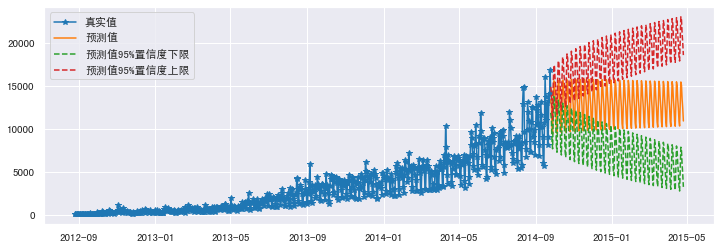

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(df, marker="*", label="真实值")
plt.plot(fcst['mean'], label="预测值")
plt.plot(fcst['mean_ci_lower'], ls='--', label="预测值95%置信度下限")
plt.plot(fcst['mean_ci_upper'], ls='--', label="预测值95%置信度上限")
plt.legend()

# 4 拆分训练集和测试集

In [23]:
df = df.reset_index()
df.head()

,ds,y
0,2012-08-25,76
1,2012-08-26,88
2,2012-08-27,62
3,2012-08-28,58
4,2012-08-29,60


In [24]:
from datetime import datetime

In [25]:
start = df['ds'][0]
end = datetime(2015, 4, 25)
start, end

(Timestamp('2012-08-25 00:00:00'), datetime.datetime(2015, 4, 25, 0, 0))

In [26]:
# 获得2012-8-25到2015-4-25中国假期的日期
holidays = get_holidays(start=start, end=end, include_weekends=False)

In [27]:
holidays_name = [get_holiday_detail(day)[1] for day in holidays]

In [28]:
# 保留字段：节假日 holiday 、日期戳 ds、lower_window 以及upper_window
# 将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散
# lower_window 以及upper_window可以理解为假日延长时限，
holiday_df = pd.DataFrame({
    "ds": holidays,
    "holiday": holidays_name,
    "lower_window": -1,
    "upper_window": 1
})

In [29]:
# holiday_df['holiday'] = holiday_df['holiday'].fillna("Weekend")

In [30]:
x_train = df.iloc[:-60]
x_test = df.iloc[-60:]

x_train.shape, x_test.shape

((702, 2), (60, 2))

# 5 Prophet建模

## 5.1 训练及预测

In [31]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays=holiday_df,
                n_changepoints=300).fit(x_train)
model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
test_forcast = model.make_future_dataframe(periods=60, freq='D')
test_forcast.shape

(762, 1)

In [33]:
test_forcast.tail()

,ds
757,2014-09-21
758,2014-09-22
759,2014-09-23
760,2014-09-24
761,2014-09-25


In [34]:
test_forcast = model.predict(test_forcast)
test_forcast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labour Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
757,2014-09-21,9692.970589,8209.601965,10127.670298,9679.213550,9707.992404,0.0,0.0,0.0,0.0,...,-960.409830,-960.409830,-960.409830,483.724484,483.724484,483.724484,0.0,0.0,0.0,9216.285242
758,2014-09-22,9715.573401,9712.123099,11584.255928,9701.506328,9731.023503,0.0,0.0,0.0,0.0,...,432.994711,432.994711,432.994711,493.976200,493.976200,493.976200,0.0,0.0,0.0,10642.544312
759,2014-09-23,9738.176213,9717.860429,11643.737945,9723.802364,9754.039836,0.0,0.0,0.0,0.0,...,434.905206,434.905206,434.905206,505.192070,505.192070,505.192070,0.0,0.0,0.0,10678.273489
760,2014-09-24,9760.779025,9797.240491,11634.799954,9746.070680,9777.218956,0.0,0.0,0.0,0.0,...,399.125539,399.125539,399.125539,517.190720,517.190720,517.190720,0.0,0.0,0.0,10677.095284
761,2014-09-25,9783.381837,9777.078204,11529.323525,9768.235701,9800.420577,0.0,0.0,0.0,0.0,...,373.319124,373.319124,373.319124,529.777319,529.777319,529.777319,0.0,0.0,0.0,10686.478280


## 5.2 测试集预测值与真实值对比

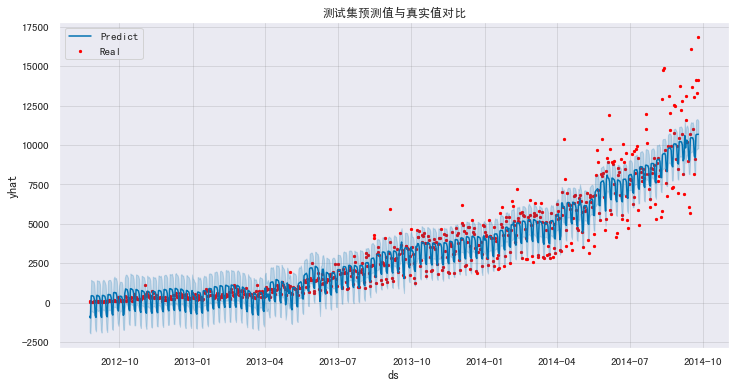

In [35]:
def plot_predict_real(df, test_forcast):
    fig = plt.figure(figsize=(12, 6))
    plt.scatter(df['ds'], df['y'], color='r', s=5)
    # 返回包含matplotlib.lines.Line2D对象的列表
    line = plot_forecast_component(model,
                                   test_forcast,
                                   'yhat',
                                   figsize=(16, 8),
                                   ax=fig.axes[0])
    # 调用Line2D对象的axes的方法在该轴上继续绘制
    line[0].axes.legend(['Predict', 'Real'])
    line[0].axes.set_title("测试集预测值与真实值对比")
    plt.show()


# 可视化测试集预测值和真实值
plot_predict_real(df, test_forcast)

## 5.3 预测未来7个月乘客数

In [36]:
delta = end - x_train['ds'].max()
fcst  = model.make_future_dataframe(delta.days, freq='D')
fcst.shape

(974, 1)

In [37]:
fcst = model.predict(fcst)
fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labour Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
969,2015-04-21,14484.766762,13586.495893,15541.188248,14330.301343,14627.724215,0.0,0.0,0.0,0.0,...,434.905206,434.905206,434.905206,-280.999724,-280.999724,-280.999724,0.0,0.0,0.0,14638.672244
970,2015-04-22,14507.369574,13635.775866,15539.366294,14352.460839,14651.372242,0.0,0.0,0.0,0.0,...,399.125539,399.125539,399.125539,-318.891287,-318.891287,-318.891287,0.0,0.0,0.0,14587.603826
971,2015-04-23,14529.972386,13560.676685,15522.271971,14374.616549,14675.026644,0.0,0.0,0.0,0.0,...,373.319124,373.319124,373.319124,-361.013695,-361.013695,-361.013695,0.0,0.0,0.0,14542.277816
972,2015-04-24,14552.575198,13348.938734,15247.802747,14396.129460,14698.670795,0.0,0.0,0.0,0.0,...,166.268751,166.268751,166.268751,-406.505982,-406.505982,-406.505982,0.0,0.0,0.0,14312.337968
973,2015-04-25,14575.178010,12360.399882,14260.629846,14417.459430,14722.281246,0.0,0.0,0.0,0.0,...,-846.203502,-846.203502,-846.203502,-454.424716,-454.424716,-454.424716,0.0,0.0,0.0,13274.549792


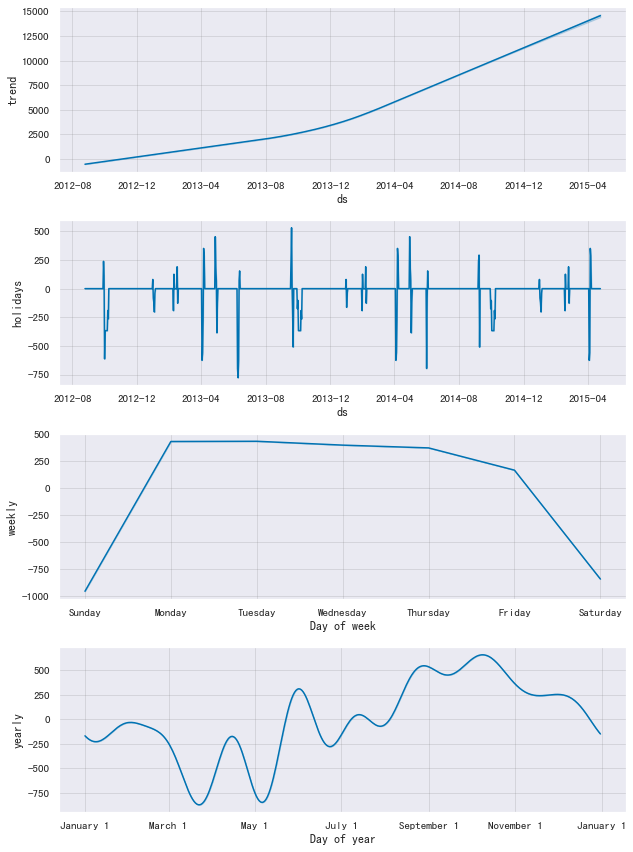

In [38]:
# 查看预测的成分分析
_ = model.plot_components(fcst)

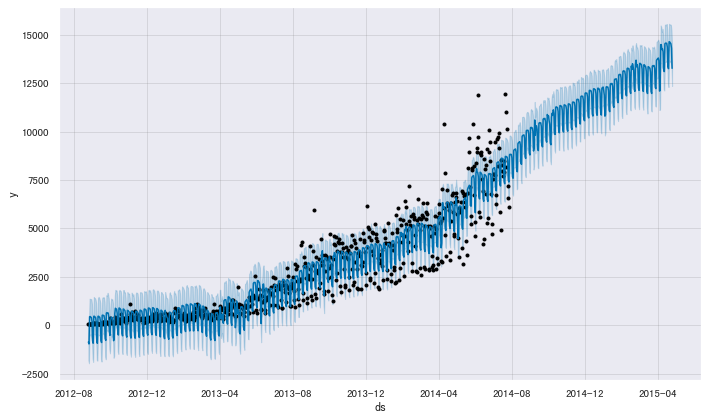

In [39]:
# 可视化未来7个月预测结果
fig = model.plot(fcst)
plt.show()

浅蓝色部分是置信区间，浅蓝色的上边界代表预测的置信区间的上边界yhat_upper，浅蓝色的下边界代表预测的置信区间的下边界值yhat_lower；黑色代表真实值；深蓝色的代表预测的平均值。    

未来7个月，每日乘客数量仍然会呈整体上升趋势；15年3月底、4月初会略降低，然后继续增长。2015年4月底预计每日乘客数约在13000-14000范围内。

# 6 总结：

- ARIMA模型预测的区间的置信区间上下限范围很大，不如Prophet的区间紧凑。

- 这次学会了通过自相关图和偏自相关图可以进行模型平稳性判断和pq阶数的判断。
- 对于如何确定时序模型的异常点还在探索中。